In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2

In [4]:
# Define image size and paths
img_size = (48, 48)  # Image size to be used for input
train_data_dir = '/kaggle/input/fer2013plus/fer2013plus/fer2013/train'
test_data_dir = '/kaggle/input/fer2013plus/fer2013plus/fer2013/test'

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of training data for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow for training with validation split
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # Training subset
)

# Flow for validation data from the same training directory
val_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation'  # Validation subset
)

# Flow for testing
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 22712 images belonging to 8 classes.
Found 5674 images belonging to 8 classes.
Found 7099 images belonging to 8 classes.


In [6]:
# Define the CNN model
model = Sequential([
    Conv2D(64, (5, 5), activation='relu', input_shape=(48, 48, 1), padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 48, 48, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,734,088 (10.43 MB)

 Trainable params: 2,733,192 (10.43 MB)

 Non-trainable params: 896 (3.50 KB)

In [9]:
# Callbacks for model training
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
checkpoint = ModelCheckpoint("best_model_tradCNN.keras", monitor='val_accuracy', save_best_only=True, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, reduce_lr, checkpoint]
)


Epoch 1/30
703/710 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5564 - loss: 1.3344
Epoch 1: val_accuracy improved from -inf to 0.57261, saving model to best_model_tradCNN.keras
710/710 ━━━━━━━━━━━━━━━━━━━━ 74s 104ms/step - accuracy: 0.5564 - loss: 1.3344 - val_accuracy: 0.5726 - val_loss: 1.2717 - learning_rate: 5.0000e-05
Epoch 2/30
703/710 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5619 - loss: 1.3232
Epoch 2: val_accuracy did not improve from 0.57261
710/710 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.5618 - loss: 1.3233 - val_accuracy: 0.5434 - val_loss: 1.3223 - learning_rate: 5.0000e-05
Epoch 3/30
705/710 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5615 - loss: 1.3258
Epoch 3: val_accuracy improved from 0.57261 to 0.59464, saving model to best_model_tradCNN.keras
710/710 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - accuracy: 0.5615 - loss: 1.3257 - val_accuracy: 0.5946 - val_loss: 1.2178 - learning_rate: 5.0000e-05
Epoch 4/30
704/710 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - 

In [13]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


178/178 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.5760 - loss: 1.2917
Validation Accuracy: 64.98%
222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.6388 - loss: 1.1522
Test Accuracy: 69.69%


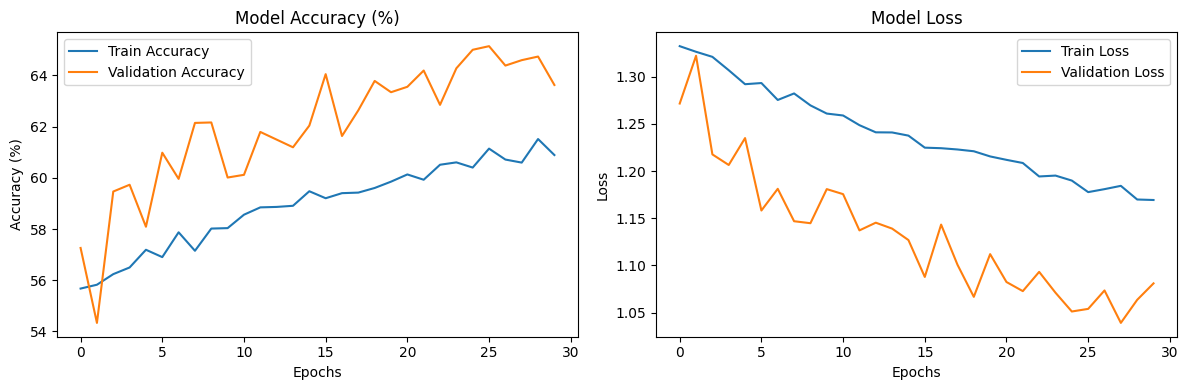

In [14]:
# Plot training history (accuracy & loss)
plt.figure(figsize=(12, 4))

# Accuracy Plot (in %)
plt.subplot(1, 2, 1)
train_acc = [a * 100 for a in history.history['accuracy']]
val_acc = [a * 100 for a in history.history['val_accuracy']]
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy (%)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
# Save the model after training
model.save('emotion_model_tradCNN_v3.h5')

Image Path: /kaggle/input/fer2013plus/fer2013plus/fer2013/test/anger/fer0028729.png
Does the image exist? True
Original image shape: (48, 48)
Input shape for model: (1, 48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Raw prediction output: [[4.1974939e-02 1.3688529e-07 4.4100452e-06 5.0787501e-02 4.2501363e-01
  6.1746134e-04 1.1256223e-03 4.8047626e-01]]
Predicted Emotion: surprise


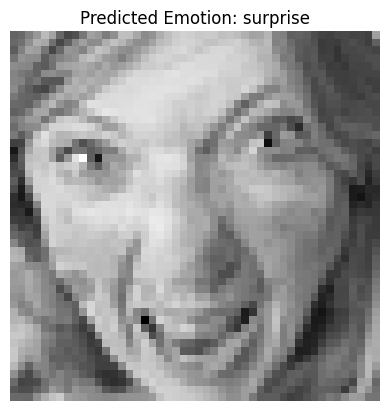

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Set image size expected by your model
img_size = (48, 48)

# Load your trained model (update path if needed)
# model = load_model('your_model_path.h5')

# Load class labels from your training generator
class_labels = list(train_generator.class_indices.keys())

# Image path
image_path = '/kaggle/input/fer2013plus/fer2013plus/fer2013/test/anger/fer0028729.png'

# Confirm path
print(f"Image Path: {image_path}")
print(f"Does the image exist? {os.path.exists(image_path)}")

def predict_emotion(image_path):
    # Step 1: Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Could not load image.")
        return
    
    print(f"Original image shape: {img.shape}")
    
    # Step 2: Resize image
    img = cv2.resize(img, img_size)
    
    # Step 3: Normalize and reshape
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)  # (48, 48, 1)
    img = np.expand_dims(img, axis=0)   # (1, 48, 48, 1)
    
    print(f"Input shape for model: {img.shape}")
    
    # Step 4: Predict emotion
    prediction = model.predict(img)
    print(f"Raw prediction output: {prediction}")
    
    predicted_label = np.argmax(prediction)
    emotion = class_labels[predicted_label]
    
    print(f"Predicted Emotion: {emotion}")
    
    # Step 5: Display image
    plt.imshow(img[0, :, :, 0], cmap='gray')
    plt.title(f"Predicted Emotion: {emotion}")
    plt.axis('off')
    plt.show()

# Call the function
predict_emotion(image_path)


Image Path: /kaggle/input/fer2013plus/fer2013plus/fer2013/test/disgust/fer0030178.png
Does the image exist? True
Original image shape: (48, 48)
Input shape for model: (1, 48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Raw prediction output: [[0.16403784 0.00543392 0.0135714  0.00151287 0.18792759 0.37928623
  0.2451457  0.00308451]]
Predicted Emotion: neutral


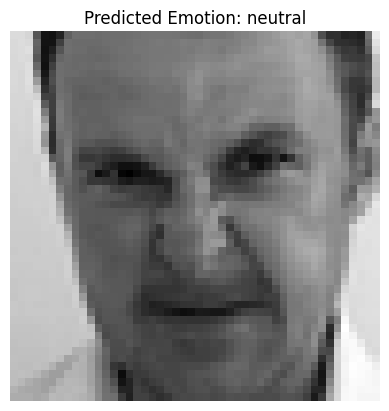

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Set image size expected by your model
img_size = (48, 48)

# Load your trained model (update path if needed)
# model = load_model('your_model_path.h5')

# Load class labels from your training generator
class_labels = list(train_generator.class_indices.keys())

# Image path
image_path = '/kaggle/input/fer2013plus/fer2013plus/fer2013/test/disgust/fer0030178.png'

# Confirm path
print(f"Image Path: {image_path}")
print(f"Does the image exist? {os.path.exists(image_path)}")

def predict_emotion(image_path):
    # Step 1: Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Could not load image.")
        return
    
    print(f"Original image shape: {img.shape}")
    
    # Step 2: Resize image
    img = cv2.resize(img, img_size)
    
    # Step 3: Normalize and reshape
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)  # (48, 48, 1)
    img = np.expand_dims(img, axis=0)   # (1, 48, 48, 1)
    
    print(f"Input shape for model: {img.shape}")
    
    # Step 4: Predict emotion
    prediction = model.predict(img)
    print(f"Raw prediction output: {prediction}")
    
    predicted_label = np.argmax(prediction)
    emotion = class_labels[predicted_label]
    
    print(f"Predicted Emotion: {emotion}")
    
    # Step 5: Display image
    plt.imshow(img[0, :, :, 0], cmap='gray')
    plt.title(f"Predicted Emotion: {emotion}")
    plt.axis('off')
    plt.show()

# Call the function
predict_emotion(image_path)
